In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import gdown

## EpiInfer Class

In [2]:
class EpiInferContact:
    def __init__(self, population_ids, contacts_history, incubation_period=7, infection_duration=7):
        """
        Initialize the EPIINFER-CONTACT system[cite: 31, 113].

        Args:
            population_ids (list): List of unique IDs for all individuals.
            contacts_history (dict): Dictionary mapping day (int) to a list of tuples [(p1, p2), ...].
            incubation_period (int): 'inc' - days between Exposed (E) and Infected (I)[cite: 225].
            infection_duration (int): 'duration' - days someone remains Infected (I)[cite: 274].
        """
        self.population = set(population_ids)
        self.contacts = contacts_history
        self.inc = incubation_period
        self.duration = infection_duration

        # Pre-process contacts for faster lookup: adj[day][person] = {set of contacts}
        self.adj = {}
        for day, meets in self.contacts.items():
            self.adj[day] = {pid: set() for pid in self.population}
            for u, v in meets:
                if u in self.adj[day]: self.adj[day][u].add(v)
                if v in self.adj[day]: self.adj[day][v].add(u)

    def _get_contacts(self, person, day):
        """Helper to get contacts of a person on a specific day."""
        if day in self.adj and person in self.adj[day]:
            return self.adj[day][person]
        return set()

    # ==========================================
    # Algorithm 3: findprob [cite: 285, 287]
    # ==========================================
    def find_prob(self, bel_asymp, s, p1, d):
        """
        Calculates probability that susceptible person 's' becomes asymptomatic
        on day 'd' given the set of currently asymptomatic people 'BelAsymp'.
        """
        count_encounters = 0
        contacts_of_s = self._get_contacts(s, d)

        # Line 3-6: Count encounters with asymptomatic individuals
        for x in contacts_of_s:
            if x in bel_asymp:
                count_encounters += 1

        # Line 8: Return 1 - (1 - p1)^countEncounters
        return 1.0 - (1.0 - p1) ** count_encounters

    # ==========================================
    # Algorithm 2: predict [cite: 281, 282]
    # ==========================================
    def predict(self, bel_asymp, bel_susc, p1, d):
        """
        Predicts the set of people who become newly asymptomatic (Exposed) on day d+1.
        """
        believed_new_asymp = set() # Line 2

        # Line 3: Iterate through susceptible population
        for s in bel_susc:
            # Line 4: Calculate probability
            p = self.find_prob(bel_asymp, s, p1, d)

            # Line 5: Draw U uniformly
            u = random.random()

            # Line 6-7: Determine if infection occurs
            if u < p:
                believed_new_asymp.add(s)

        return believed_new_asymp # Line 10

    # ==========================================
    # Algorithm 1: EpiInfer-Core [cite: 272, 280]
    # ==========================================
    def contact_infer_core(self, p1, p2, initial_infected_data, start_day, end_day, known_immune=None):
        """
        Projects future infection rates using contact tracing data.
        """
        # History tracking
        hist_new_asymp = {}
        hist_new_inf = {}

        # --- Initialization Phase  ---
        # Estimate initial asymptomatic pool based on Infected(d) and p2.
        # "Infected(d)/p2 people in the asymptomatic status at d-inc"
        initial_infected_count = len(initial_infected_data)
        if initial_infected_count > 0 and p2 > 0:
            est_total_asymp = int(initial_infected_count / p2)
            # Logic to assign these preferentially to high-contact people (simplified implementation)
            # For this code, we assume 'initial_infected_data' passed in might already be the estimated set,
            # or we seed the simulation with a basic set if specific history isn't provided.
            # Here we seed simply for the simulation loop:
            hist_new_asymp[start_day] = set(initial_infected_data)
        else:
            hist_new_asymp[start_day] = set()

        hist_new_inf[start_day] = set()
        current_immune = set(known_immune) if known_immune else set()

        # Helper: BelievedAsymptomatic(e) = Union of NewAsymp from (e-inc) to e [cite: 280]
        def get_believed_asymp(curr_day):
            union_set = set()
            for d in range(curr_day - self.inc + 1, curr_day + 1):
                if d in hist_new_asymp:
                    union_set.update(hist_new_asymp[d])
            return union_set

        # Helper: BelievedInf(e) = Union of NewInf from (e-duration) to e [cite: 274]
        def get_believed_inf(curr_day):
            union_set = set()
            for d in range(curr_day - self.duration + 1, curr_day + 1):
                if d in hist_new_inf:
                    union_set.update(hist_new_inf[d])
            return union_set

        # --- Main Simulation Loop (Line 7) ---
        for d in range(start_day, end_day):
            # Maintain Invariants [cite: 280]
            bel_asymp_d = get_believed_asymp(d)
            bel_inf_d = get_believed_inf(d)

            # BelievedSusc(d) calculation (Line 5)
            non_susc = bel_asymp_d.union(bel_inf_d).union(current_immune)
            bel_susc_d = self.population - non_susc

            # Line 8: Predict New Asymptomatic for d+1
            new_asymp_next = self.predict(bel_asymp_d, bel_susc_d, p1, d)
            hist_new_asymp[d+1] = new_asymp_next

            # Line 9: Calculate New Infected for d+1
            # "Choose each member of BelievedNewAsymp(d+1-inc) with probability p2"
            source_day = (d + 1) - self.inc
            new_inf_next = set()

            if source_day in hist_new_asymp:
                candidates = hist_new_asymp[source_day]
                for person in candidates:
                    if random.random() < p2:
                        new_inf_next.add(person)
                    # The rest return to susceptible pool (implicitly by not entering Inf state) [cite: 279]

            hist_new_inf[d+1] = new_inf_next

        # Return daily counts of new infections (Line 10)
        results = {d: len(s) for d, s in hist_new_inf.items()}
        return results

    # ==========================================
    # Algorithm 4: ContinuousCalibrate [cite: 324, 326]
    # ==========================================
    def continuous_calibrate(self, training_data, training_days_window, initial_asymp, start_day):
        """
        Systematic Search for p1 and p2 minimizing RMSE.
        """
        best_rmse = float('inf')
        best_p1, best_p2 = 0.5, 0.5

        max_day = max(training_data.keys())
        rmse_start_day = max_day - training_days_window + 1

        # Line 2: Iterate p2 from 0.1 to 1.0
        for p2 in [round(x * 0.1, 1) for x in range(1, 11)]:

            # Line 3: Binary Search on p1
            low = 0.0
            high = 1.0

            # Fixed iterations for binary search approximation
            for _ in range(10):
                curr_p1 = (low + high) / 2.0

                # Line 4: Run EpiInfer-core
                pred_counts = self.contact_infer_core(curr_p1, p2, initial_asymp, start_day, max_day)

                # Line 5: Calculate RMSE for last t days
                sq_err_sum = 0
                count = 0
                pred_sum = 0
                real_sum = 0

                for d in range(rmse_start_day, max_day + 1):
                    if d in pred_counts and d in training_data:
                        pred = pred_counts[d]
                        real = training_data[d]
                        sq_err_sum += (pred - real) ** 2
                        pred_sum += pred
                        real_sum += real
                        count += 1

                if count == 0: break

                rmse = math.sqrt(sq_err_sum / count)

                # Line 6: Update best p1, p2
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_p1 = curr_p1
                    best_p2 = p2

                # Line 7: Update interval for p1
                # Logic: If predicted > real, need lower p1. Else higher p1. [cite: 320]
                if pred_sum > real_sum:
                    high = curr_p1
                else:
                    low = curr_p1

        return best_p1, best_p2 # Line 10

In [3]:
# ==========================================
# 2. EXTENSION FOR ROLLING HISTORY
# ==========================================
class EpiInferContactRolling(EpiInferContact):
    """
    Extends original class to allow injecting full history buffers.
    This enables valid '1-day ahead' predictions without a 7-day warm-up period.
    """
    def contact_infer_core_with_history(self, p1, p2, history_asymp, history_inf, start_day, end_day, known_immune):
        # Local state initialized with PASSED history instead of empty dicts
        hist_new_asymp = history_asymp.copy()
        hist_new_inf = history_inf.copy()
        current_immune = set(known_immune) if known_immune else set()

        # Re-defining helpers locally to capture the local 'hist_new_asymp' closure
        def get_believed_asymp(curr_day):
            union_set = set()
            for d in range(curr_day - self.inc + 1, curr_day + 1):
                if d in hist_new_asymp: union_set.update(hist_new_asymp[d])
            return union_set

        def get_believed_inf(curr_day):
            union_set = set()
            for d in range(curr_day - self.duration + 1, curr_day + 1):
                if d in hist_new_inf: union_set.update(hist_new_inf[d])
            return union_set

        results = {}
        for d in range(start_day, end_day):
            bel_asymp_d = get_believed_asymp(d)
            bel_inf_d = get_believed_inf(d)
            recovered_d = set()
            for past_d, inf_set in hist_new_inf.items():
                if past_d + self.duration <= d: recovered_d.update(inf_set)

            non_susc = bel_asymp_d.union(bel_inf_d).union(current_immune).union(recovered_d)
            bel_susc_d = self.population - non_susc

            new_asymp_next = self.predict(bel_asymp_d, bel_susc_d, p1, d)
            hist_new_asymp[d+1] = new_asymp_next

            source_day = (d + 1) - self.inc
            new_inf_next = set()
            if source_day in hist_new_asymp:
                candidates = hist_new_asymp[source_day]
                for person in candidates:
                    if random.random() < p2: new_inf_next.add(person)
            hist_new_inf[d+1] = new_inf_next

        for d in range(start_day + 1, end_day + 1):
             active = set()
             for lookback in range(d - self.duration + 1, d + 1):
                 if lookback in hist_new_inf: active.update(hist_new_inf[lookback])
             results[d] = len(active)
        return results

In [4]:
gdown.download('https://drive.google.com/file/d/1gqGlIw9XDlWsmf4oiNS7lDc15vIBk-nf/view?usp=sharing', fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1gqGlIw9XDlWsmf4oiNS7lDc15vIBk-nf
From (redirected): https://drive.google.com/uc?id=1gqGlIw9XDlWsmf4oiNS7lDc15vIBk-nf&confirm=t&uuid=7771f434-431f-41b2-b66b-e13e98a145db
To: /content/New results-20260116T150546Z-1-001.zip
100%|██████████| 72.2M/72.2M [00:01<00:00, 60.8MB/s]


'New results-20260116T150546Z-1-001.zip'

In [5]:
!ls -ltrh

total 69M
drwxr-xr-x 1 root root 4.0K Dec 11 14:34  sample_data
-rw-r--r-- 1 root root  69M Jan 16 15:17 'New results-20260116T150546Z-1-001.zip'


In [6]:
!unzip 'New results-20260116T150546Z-1-001.zip'

Archive:  New results-20260116T150546Z-1-001.zip
  inflating: New results/p1_0.12_p2_0.05/repeated_meetings_by_day_with_age.csv  
  inflating: New results/p1_0.12_p2_0.05/.DS_Store  
  inflating: New results/p1_0.25_p2_0.1/.DS_Store  
  inflating: New results/p1_0.12_p2_0.1/states_total.csv  
  inflating: New results/p1_0.12_p2_0.05/states_total.csv  
  inflating: New results/p1_0.25_p2_0.1/states_total.csv  
  inflating: New results/p1_0.12_p2_0.1/.DS_Store  
  inflating: New results/p1_0.2_p2_0.2/states_total.csv  
  inflating: New results/p1_0.2_p2_0.1/.DS_Store  
  inflating: New results/p1_0.15_p2_0.05/states_total.csv  
  inflating: New results/p1_0.2_p2_0.2/.DS_Store  
  inflating: New results/p1_0.15_p2_0.05/.DS_Store  
  inflating: New results/p1_0.2_p2_0.05/repeated_meetings_by_day_with_age.csv  
  inflating: New results/p1_0.2_p2_0.2/repeated_meetings_by_day_with_age.csv  
  inflating: New results/p1_0.25_p2_0.1/repeated_meetings_by_day_with_age.csv  
  inflating: New result

In [7]:
!mv 'New results' data

In [8]:
!ls -ltr data/

total 48
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.2_p2_0.2
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.25_p2_0.1
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.12_p2_0.1
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.15_p2_0.05
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.2_p2_0.1
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.15_p2_0.1
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.2_p2_0.05
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.12_p2_0.05
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.25_p2_0.05
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.15_p2_0.2
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.25_p2_0.2
drwxr-xr-x 2 root root 4096 Jan 16 17:05 p1_0.12_p2_0.2


## For p1=0.2 & p2=0.2

In [9]:
!ls -ltrh data/p1_0.2_p2_0.2/

total 20M
-rw-r--r-- 1 root root 7.4M Jan 15 17:03 timed_edges.csv
-rw-r--r-- 1 root root 2.1K Jan 15 17:03 states_total.csv
-rw-r--r-- 1 root root  13M Jan 15 17:03 repeated_meetings_by_day_with_age.csv


In [10]:
!head data/p1_0.2_p2_0.2/states_total.csv

day,S,A,I,R
0,1992,8,0,0
1,1977,23,0,0
2,1941,59,0,0
3,1843,157,0,0
4,1655,345,0,0
5,1325,675,0,0
6,868,1132,0,0
7,506,1492,2,0
8,247,1747,6,0


In [11]:
!head data/p1_0.2_p2_0.2/timed_edges.csv

day,i,j
1,175,904
1,211,332
1,123,219
1,73,627
1,141,502
1,850,1716
1,313,1777
1,932,1260
1,1405,1709


In [12]:
p = [(0.2, 0.2), (0.25, 0.1), (0.12, 0.1), (0.15, 0.05), (0.2, 0.1), (0.15, 0.1), (0.2, 0.05), (0.12, 0.05), (0.25, 0.05), (0.15, 0.2), (0.25, 0.2), (0.12, 0.2)]

Processing Contact Graph for 0.2,0.2...
Plots saved.


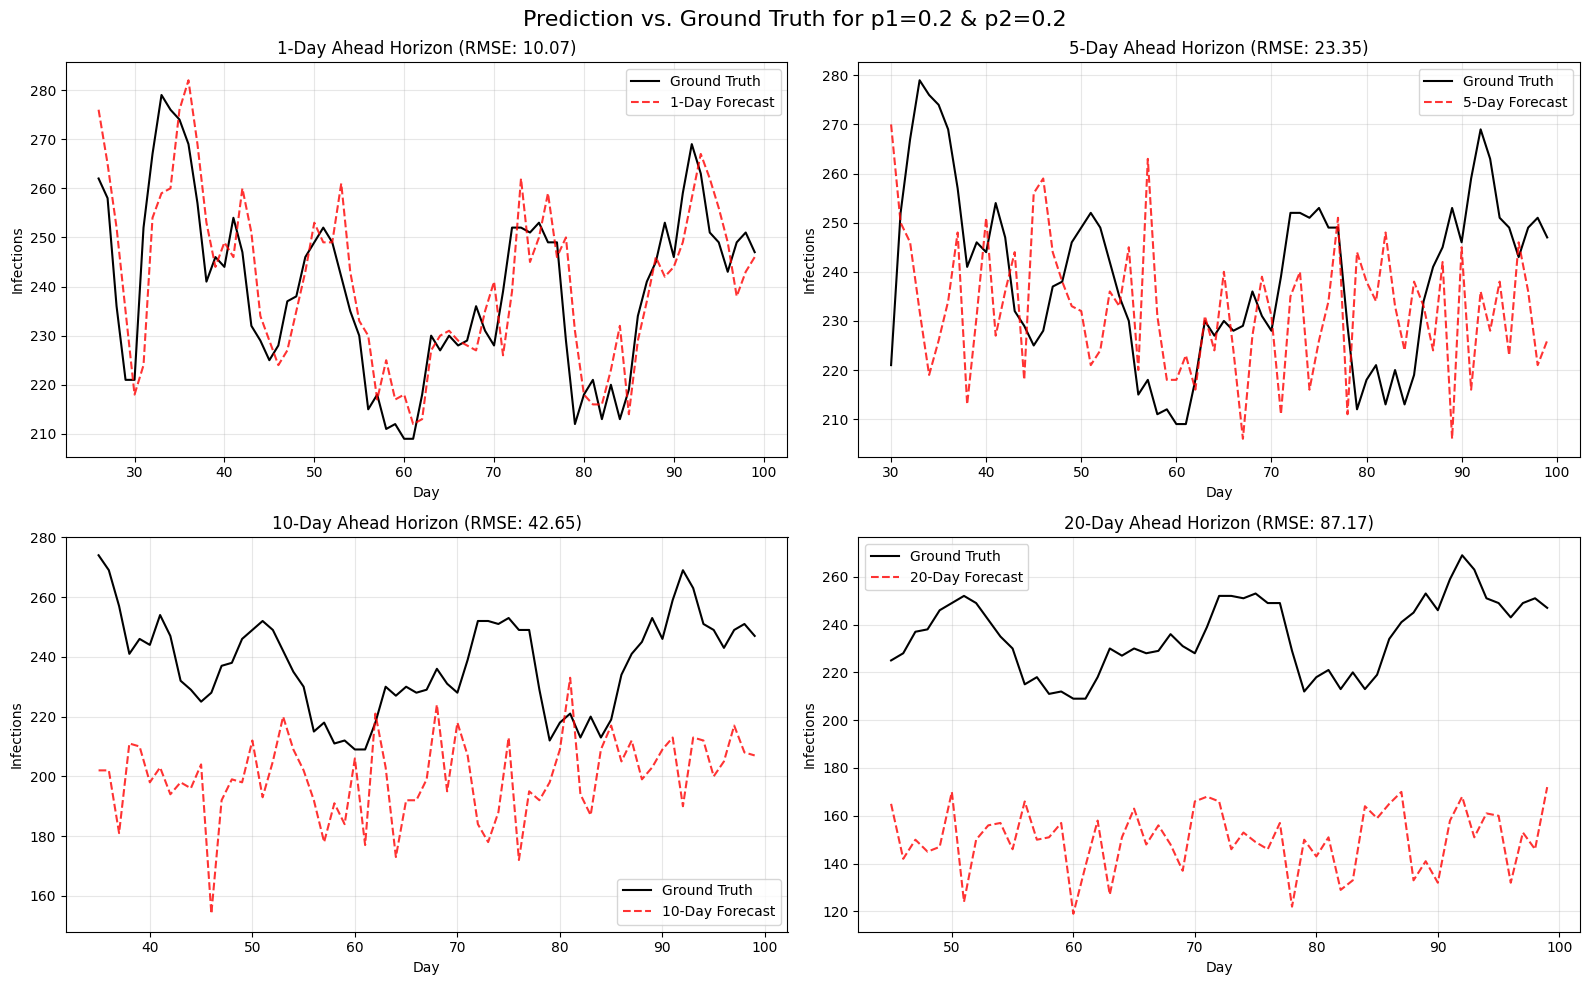


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        276     262
       1           26          27        265     258
       1           27          28        252     236
       1           28          29        235     221
       1           29          30        218     221

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        270     221
       5           26          31        250     252
       5           27          32        246     267
       5           28          33        232     279
       5           29          34        219     276

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        202     274
      10           26          36        202     269
      10           27          37        181     257
      10           28          38        211     241
      10

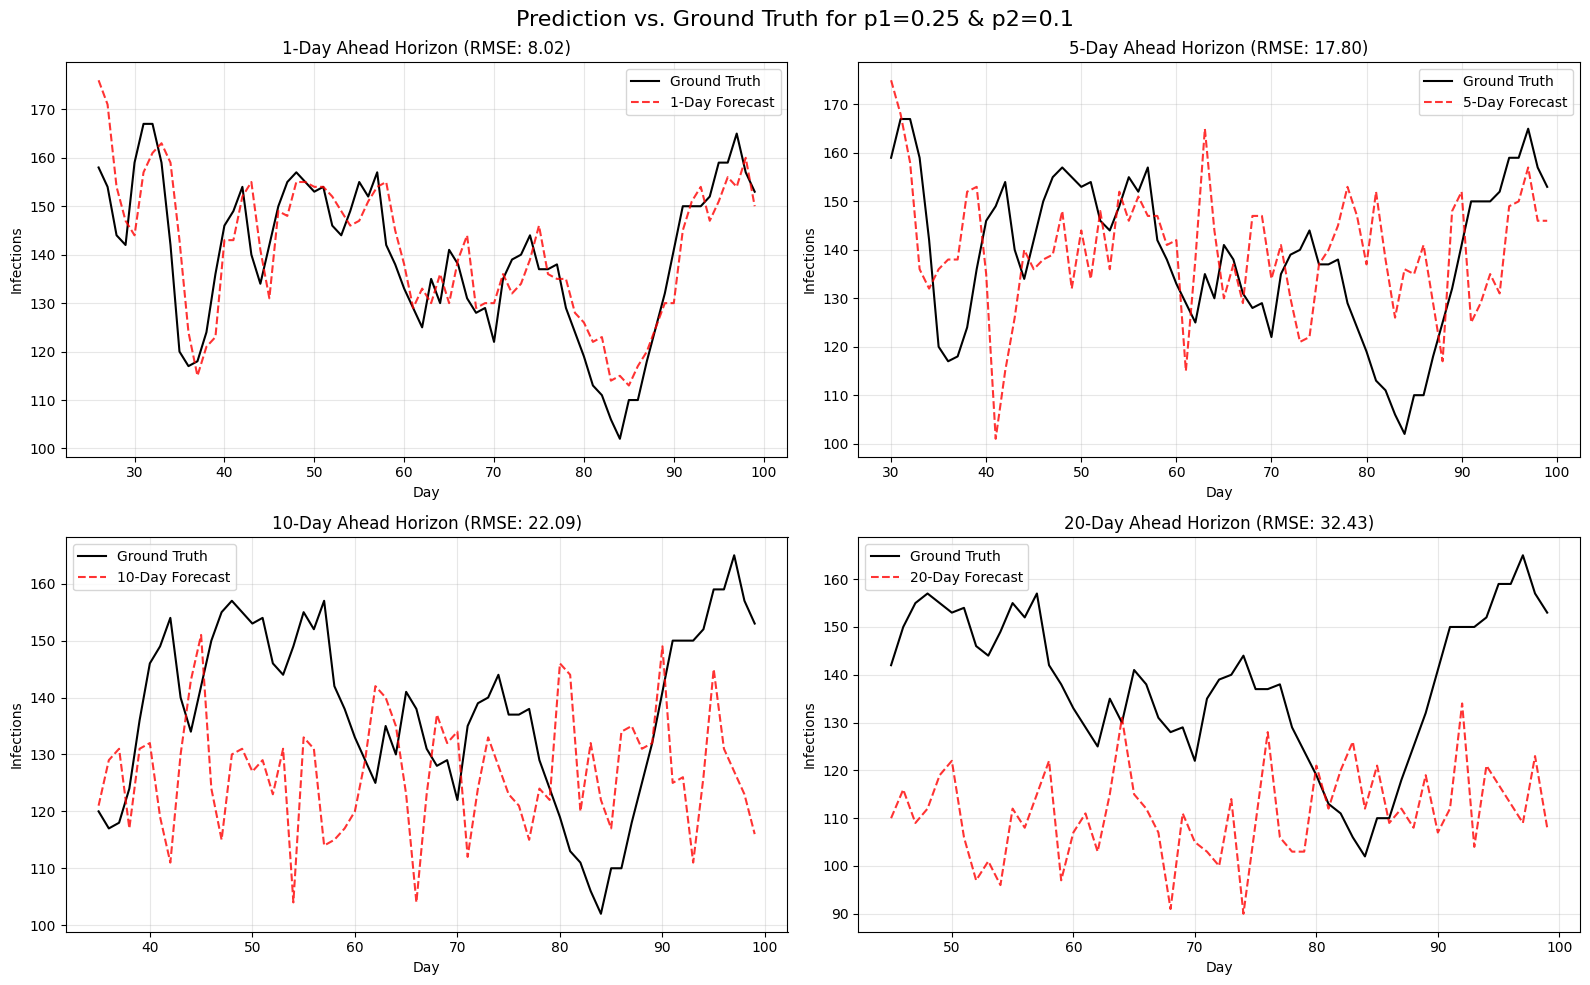


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        176     158
       1           26          27        171     154
       1           27          28        154     144
       1           28          29        147     142
       1           29          30        144     159

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        175     159
       5           26          31        168     167
       5           27          32        158     167
       5           28          33        136     159
       5           29          34        132     142

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        121     120
      10           26          36        129     117
      10           27          37        131     118
      10           28          38        117     124
      10

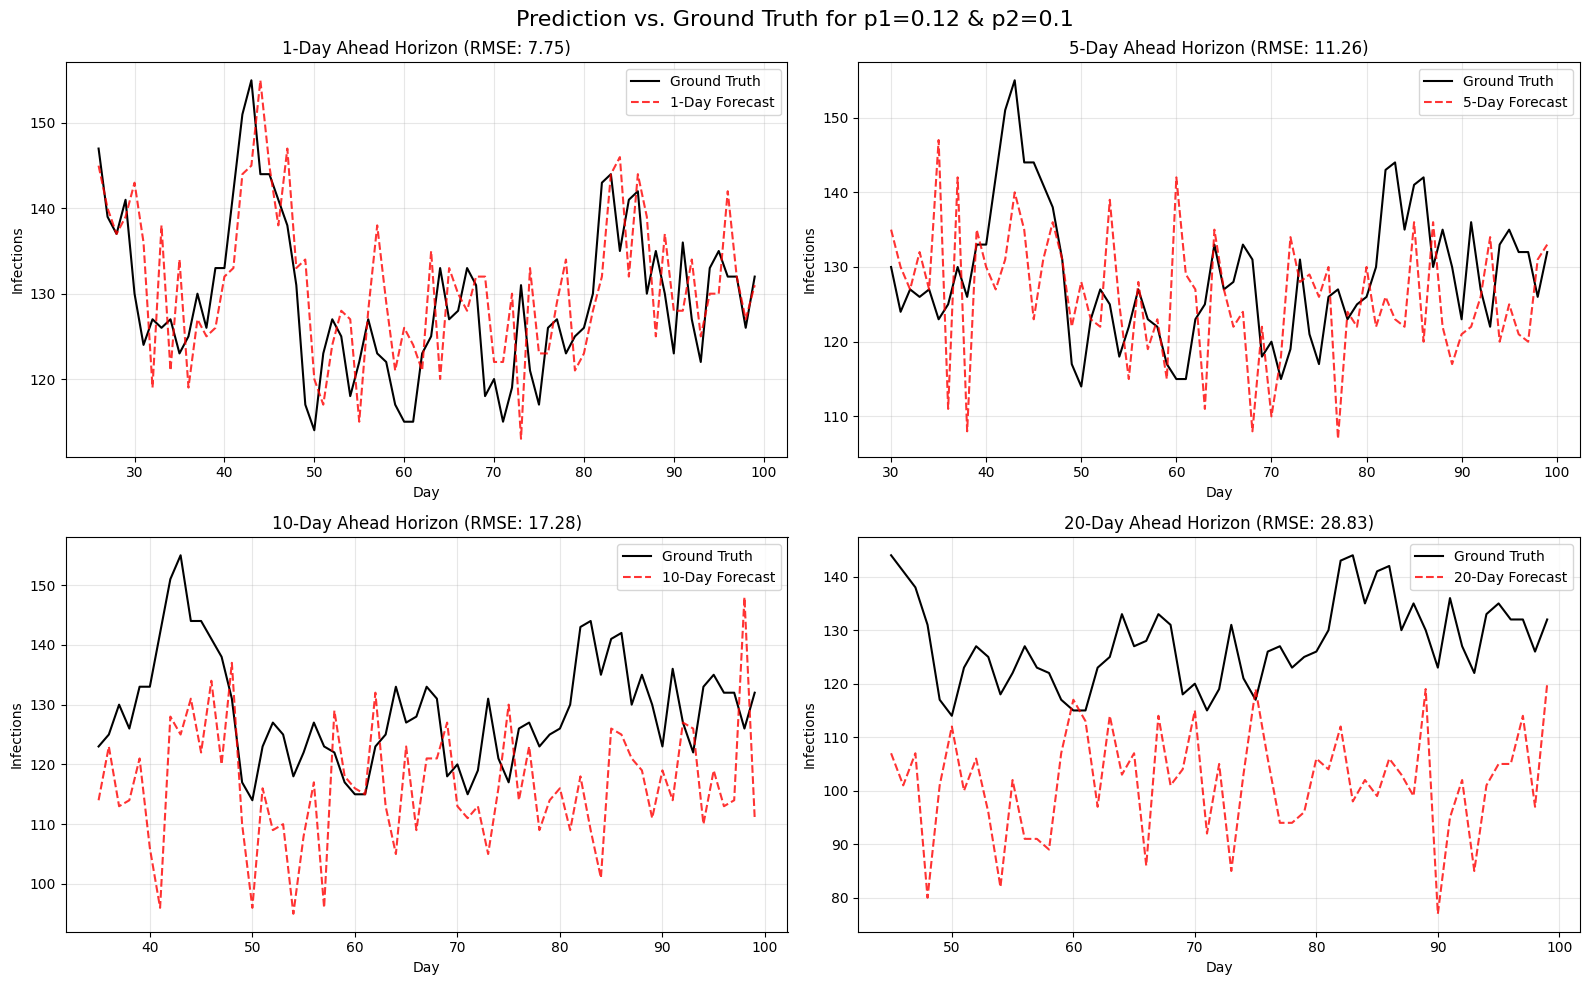


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        145     147
       1           26          27        140     139
       1           27          28        137     137
       1           28          29        139     141
       1           29          30        143     130

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        135     130
       5           26          31        130     124
       5           27          32        127     127
       5           28          33        132     126
       5           29          34        127     127

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        114     123
      10           26          36        123     125
      10           27          37        113     130
      10           28          38        114     126
      10

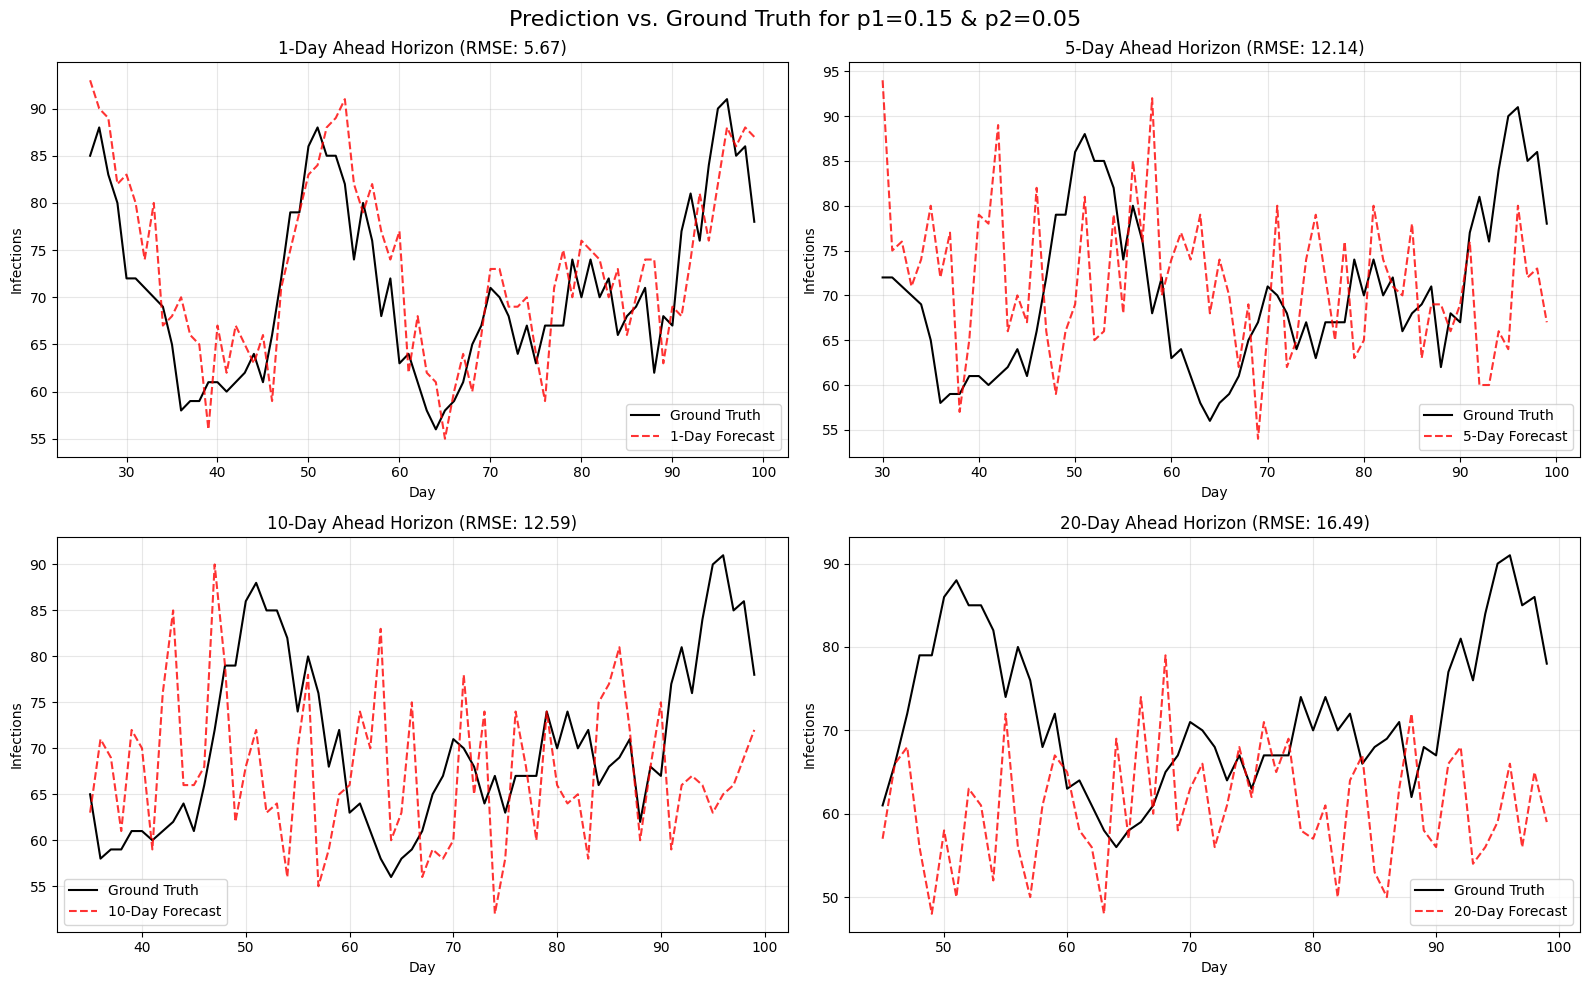


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26         93      85
       1           26          27         90      88
       1           27          28         89      83
       1           28          29         82      80
       1           29          30         83      72

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30         94      72
       5           26          31         75      72
       5           27          32         76      71
       5           28          33         71      70
       5           29          34         74      69

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35         63      65
      10           26          36         71      58
      10           27          37         69      59
      10           28          38         61      59
      10

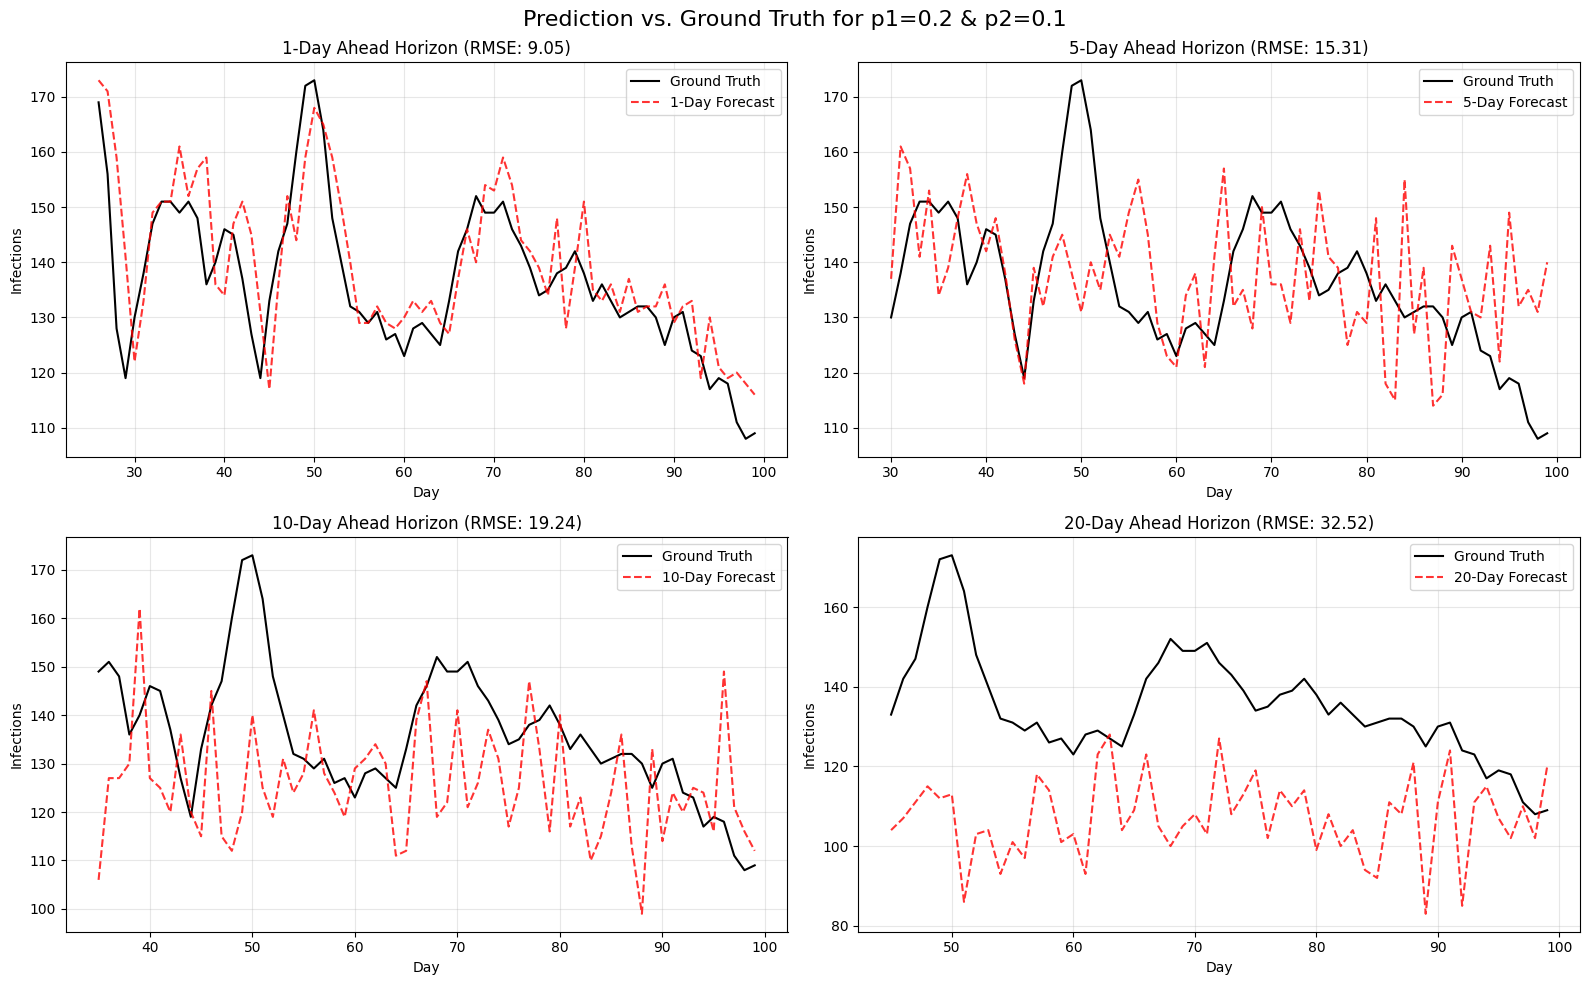


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        173     169
       1           26          27        171     156
       1           27          28        159     128
       1           28          29        141     119
       1           29          30        122     130

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        137     130
       5           26          31        161     138
       5           27          32        157     147
       5           28          33        141     151
       5           29          34        153     151

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        106     149
      10           26          36        127     151
      10           27          37        127     148
      10           28          38        130     136
      10

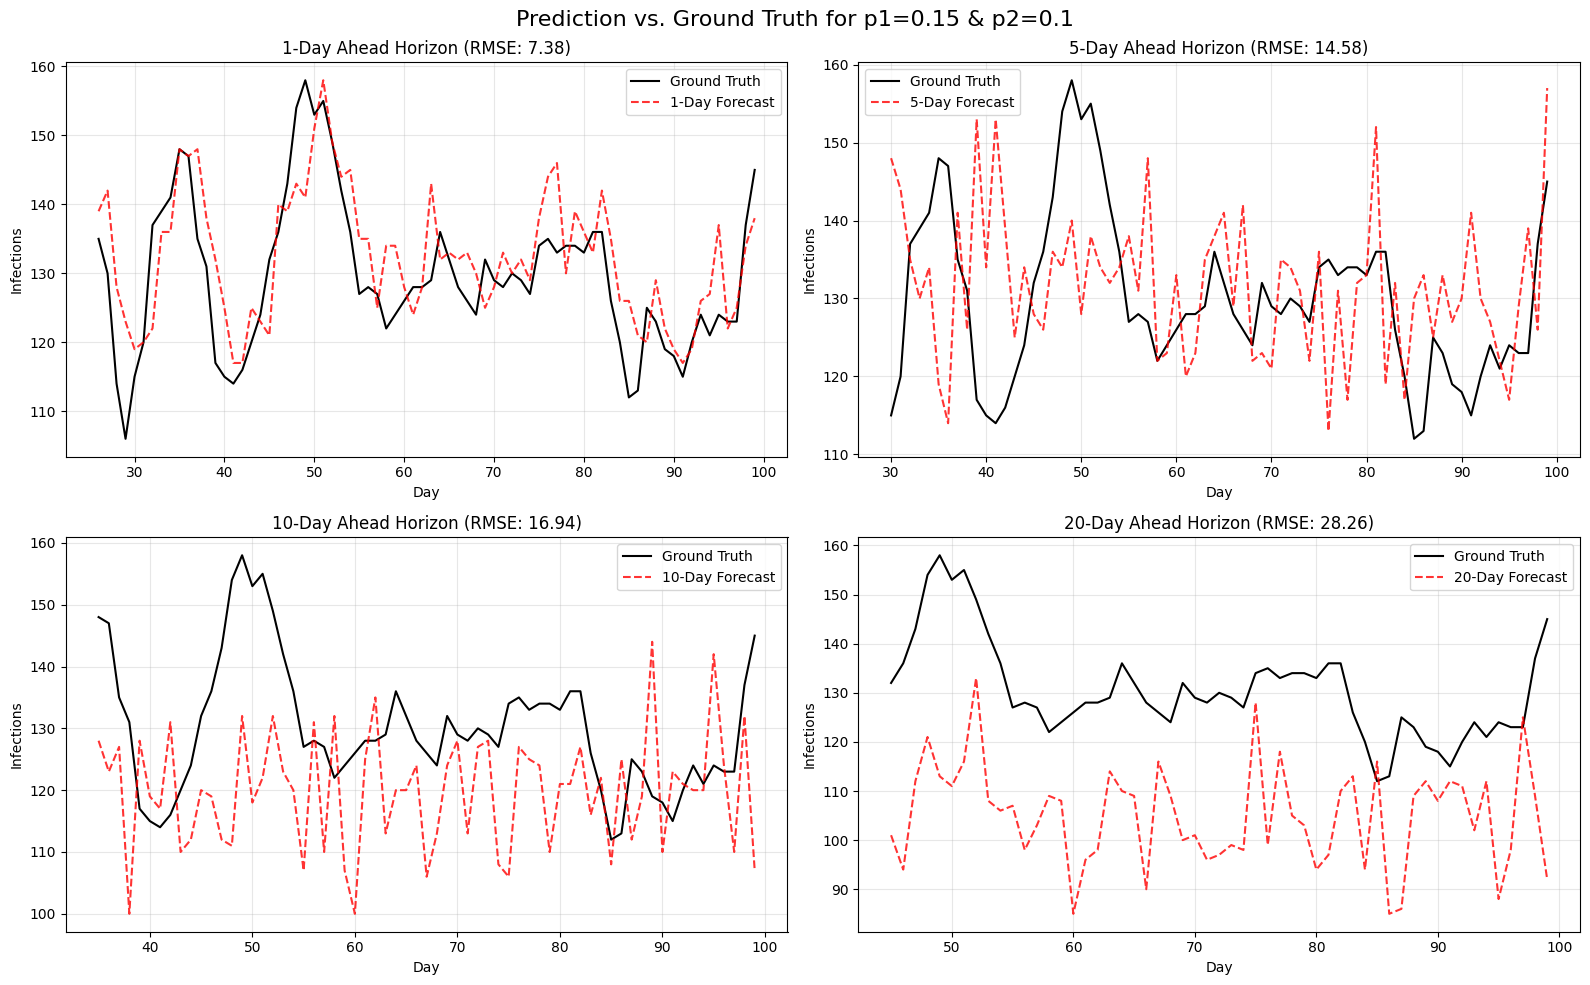


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        139     135
       1           26          27        142     130
       1           27          28        128     114
       1           28          29        123     106
       1           29          30        119     115

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        148     115
       5           26          31        144     120
       5           27          32        135     137
       5           28          33        130     139
       5           29          34        134     141

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        128     148
      10           26          36        123     147
      10           27          37        127     135
      10           28          38        100     131
      10

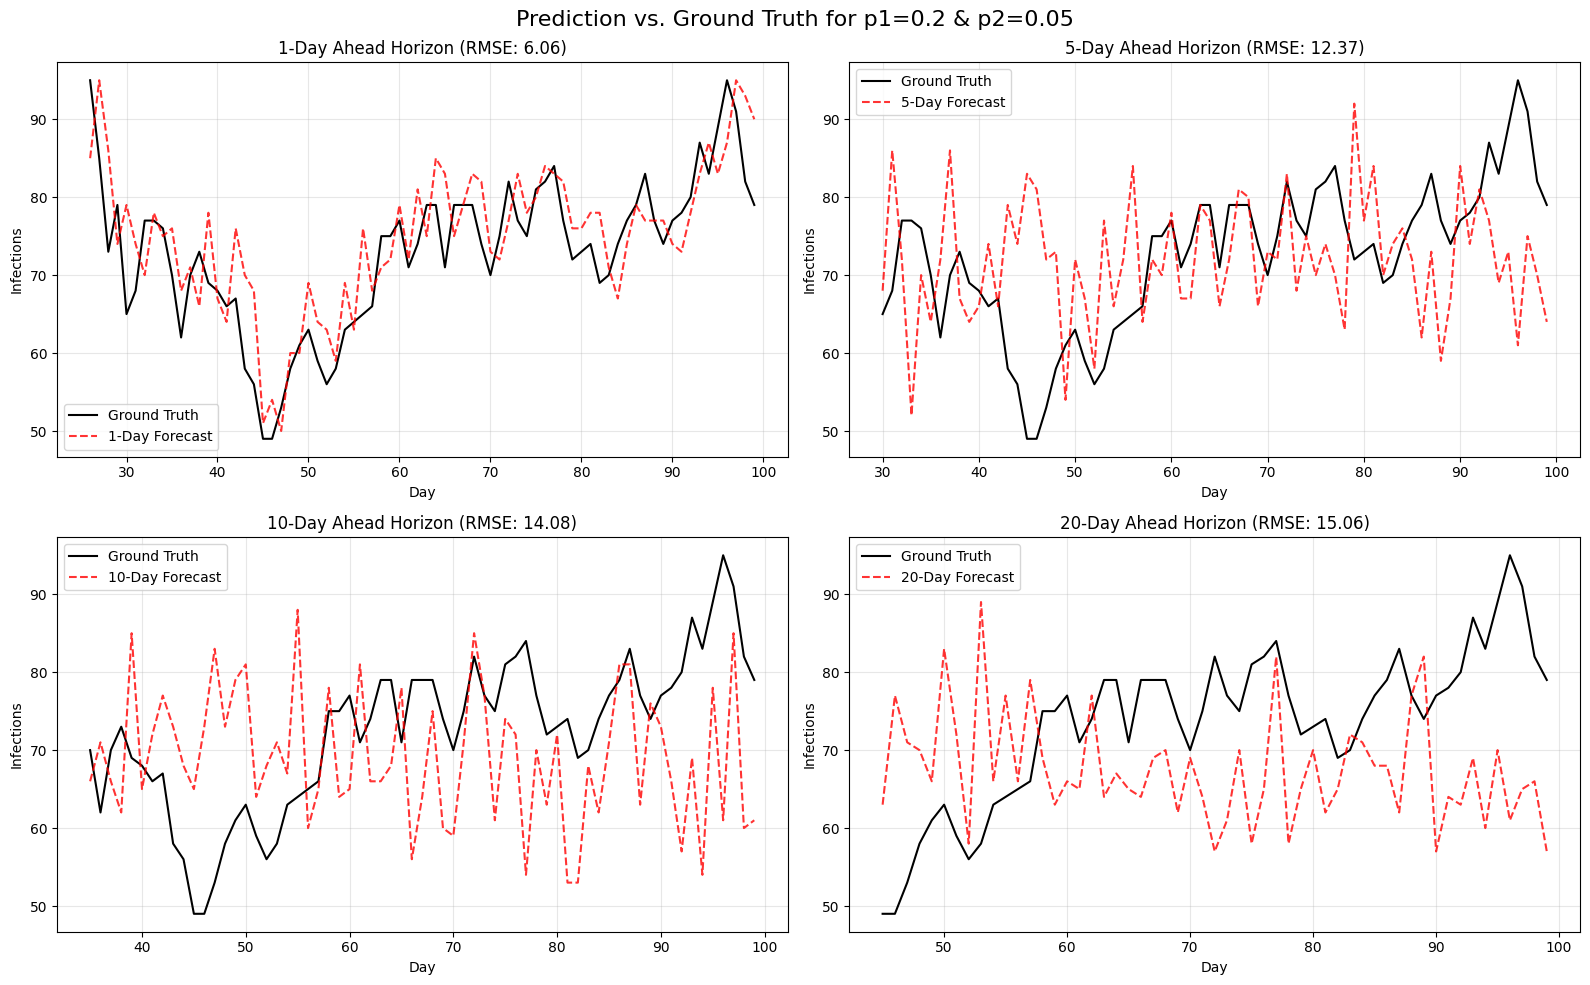


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26         85      95
       1           26          27         95      85
       1           27          28         86      73
       1           28          29         74      79
       1           29          30         79      65

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30         68      65
       5           26          31         86      68
       5           27          32         72      77
       5           28          33         52      77
       5           29          34         70      76

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35         66      70
      10           26          36         71      62
      10           27          37         66      70
      10           28          38         62      73
      10

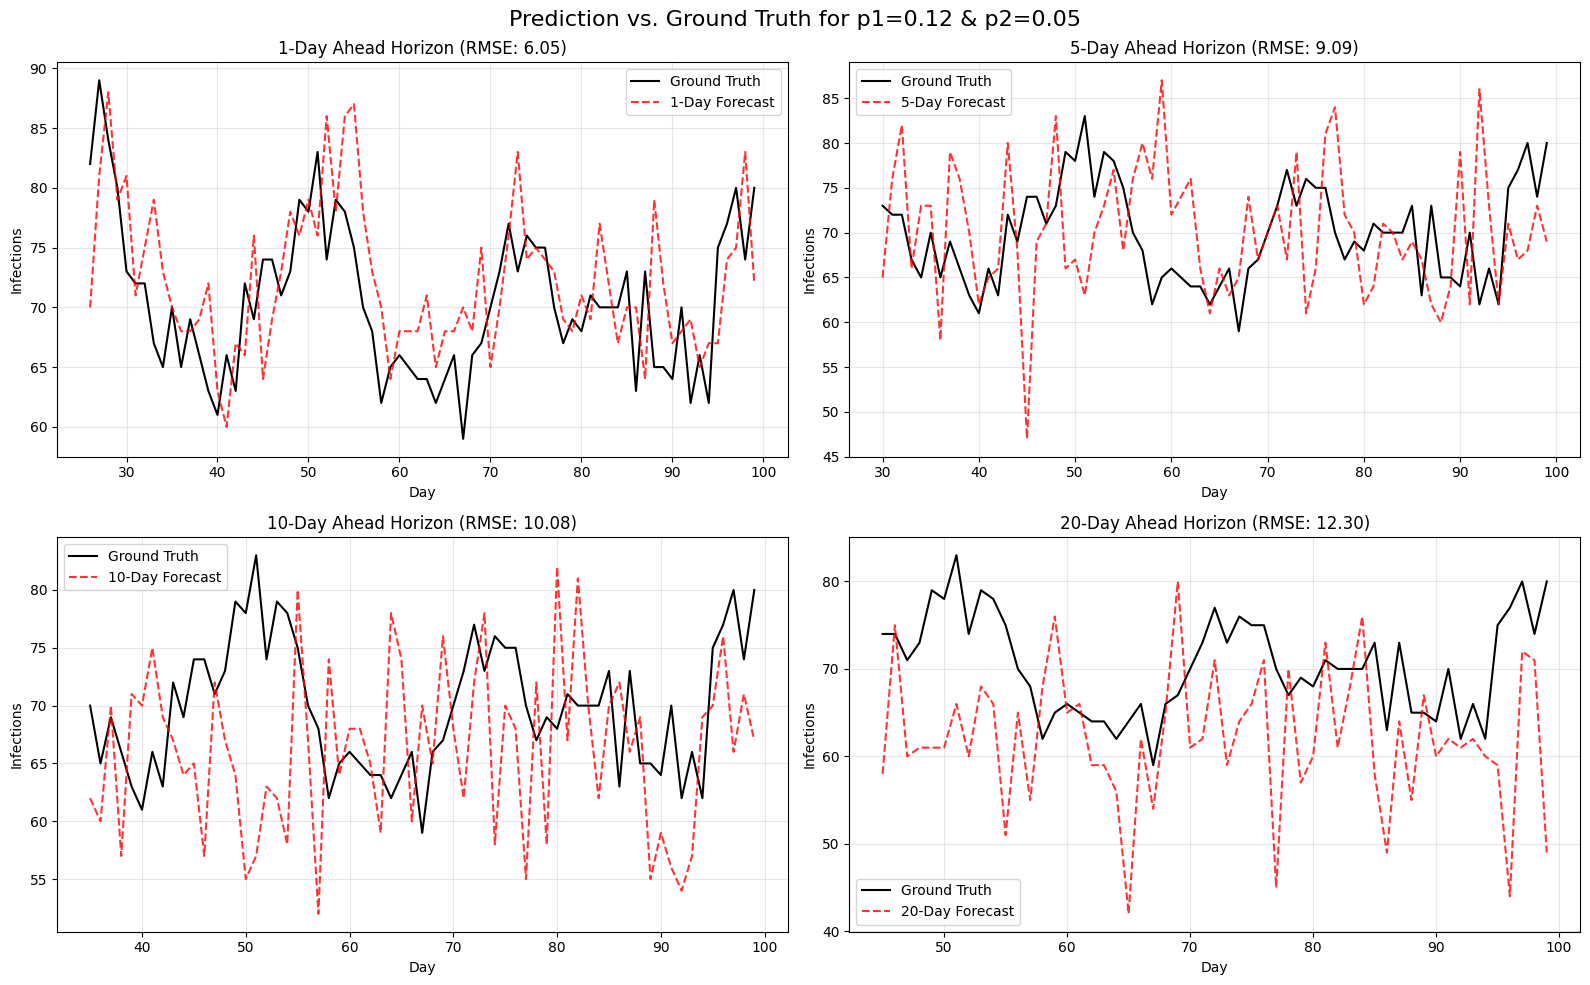


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26         70      82
       1           26          27         81      89
       1           27          28         88      84
       1           28          29         79      80
       1           29          30         81      73

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30         65      73
       5           26          31         76      72
       5           27          32         82      72
       5           28          33         66      67
       5           29          34         73      65

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35         62      70
      10           26          36         60      65
      10           27          37         70      69
      10           28          38         57      66
      10

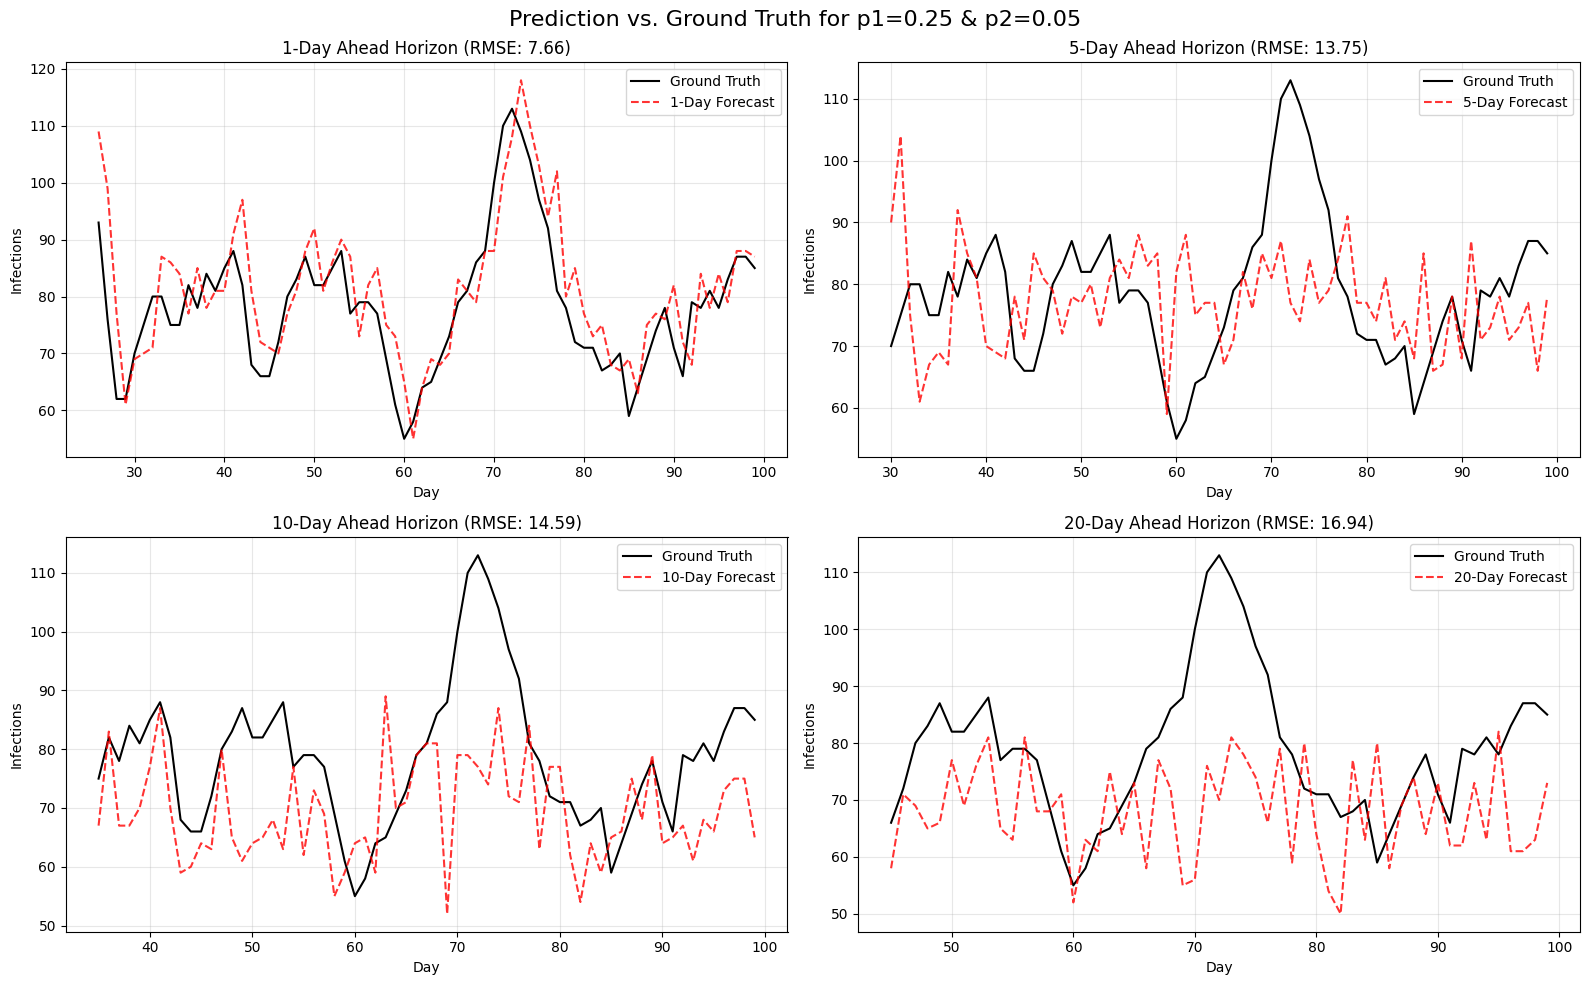


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        109      93
       1           26          27         99      76
       1           27          28         77      62
       1           28          29         61      62
       1           29          30         69      70

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30         90      70
       5           26          31        104      75
       5           27          32         75      80
       5           28          33         61      80
       5           29          34         67      75

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35         67      75
      10           26          36         83      82
      10           27          37         67      78
      10           28          38         67      84
      10

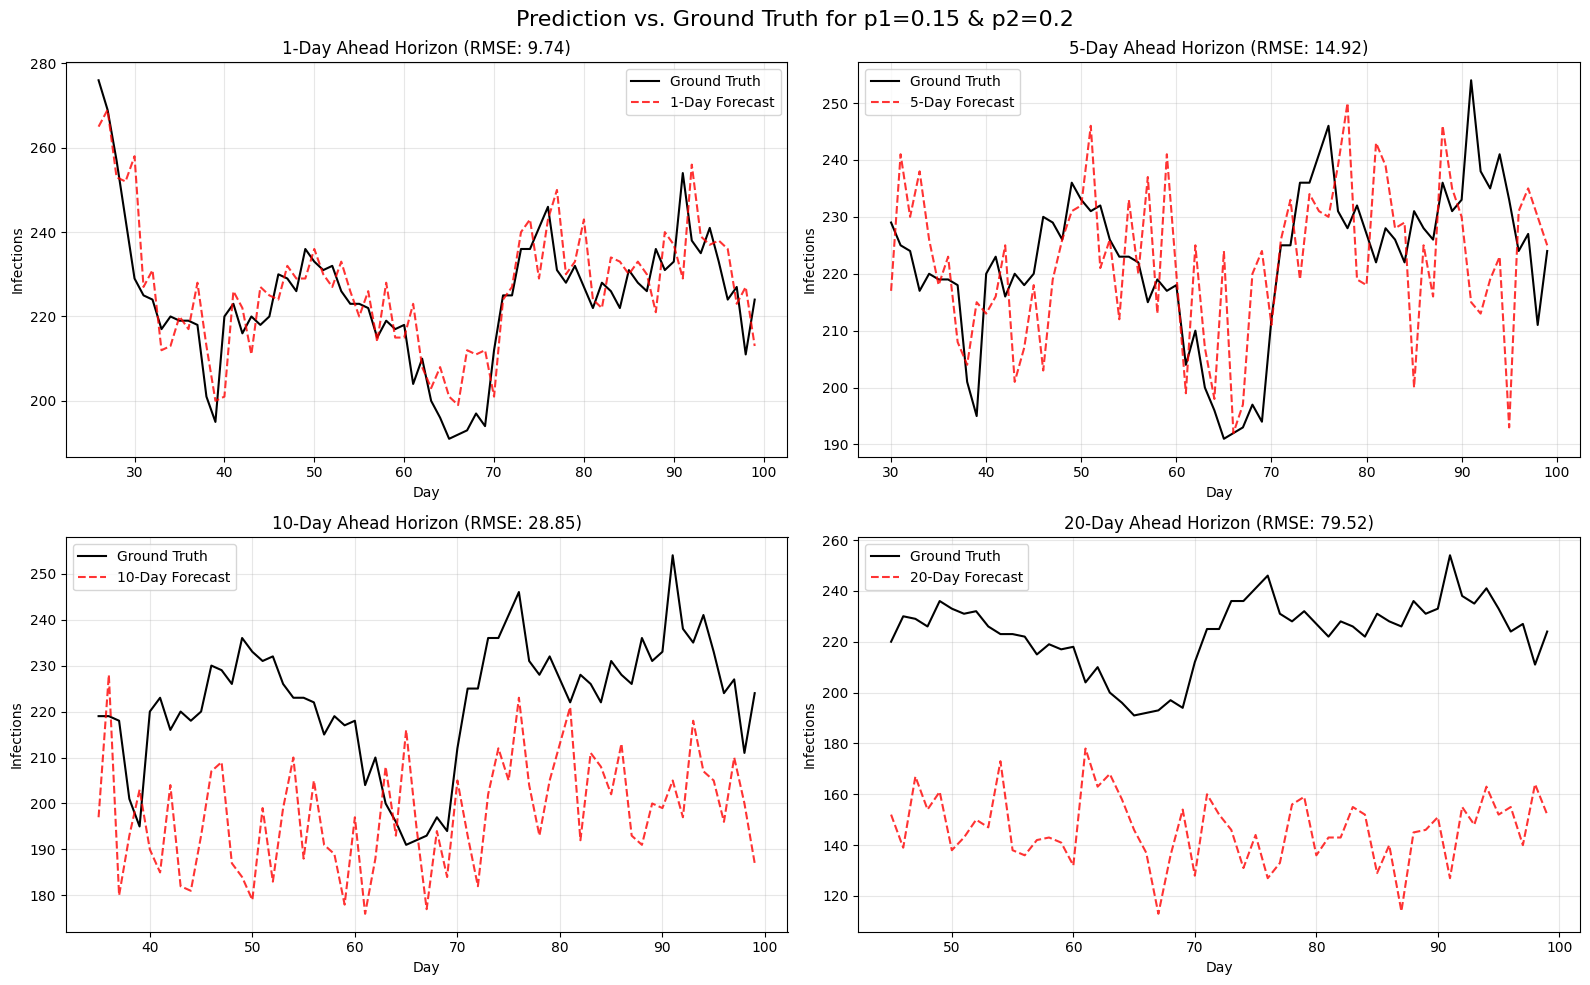


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        265     276
       1           26          27        269     269
       1           27          28        253     257
       1           28          29        252     243
       1           29          30        258     229

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        217     229
       5           26          31        241     225
       5           27          32        230     224
       5           28          33        238     217
       5           29          34        226     220

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        197     219
      10           26          36        228     219
      10           27          37        180     218
      10           28          38        193     201
      10

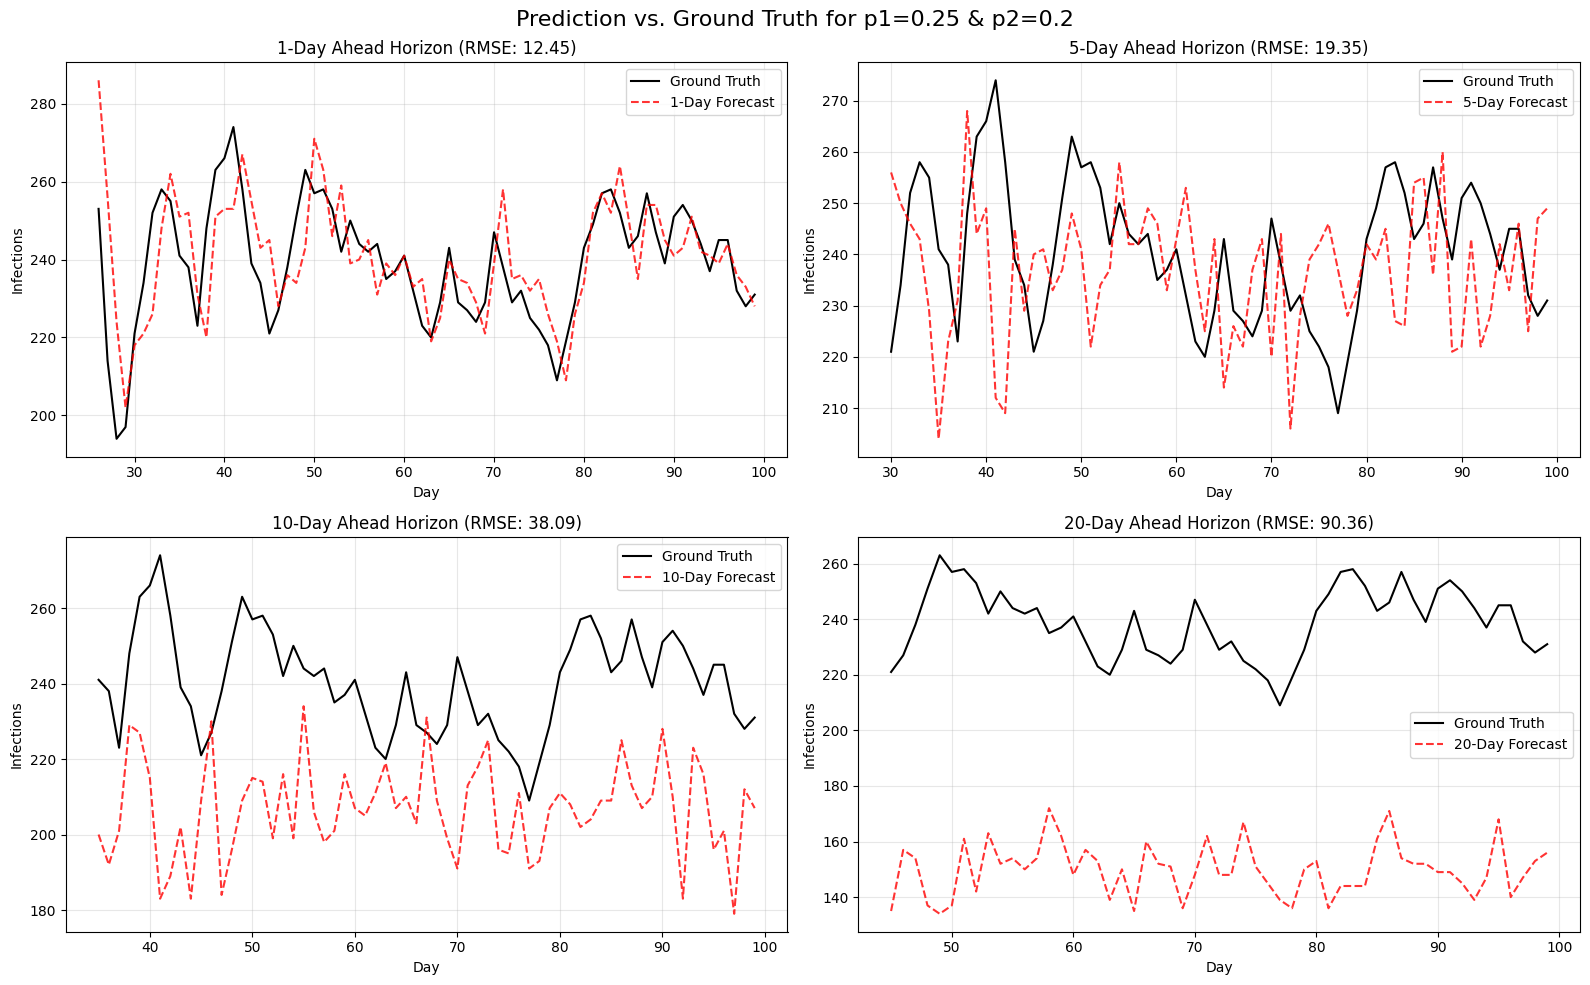


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        286     253
       1           26          27        256     214
       1           27          28        224     194
       1           28          29        202     197
       1           29          30        218     221

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        256     221
       5           26          31        250     234
       5           27          32        246     252
       5           28          33        243     258
       5           29          34        229     255

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        200     241
      10           26          36        192     238
      10           27          37        201     223
      10           28          38        229     248
      10

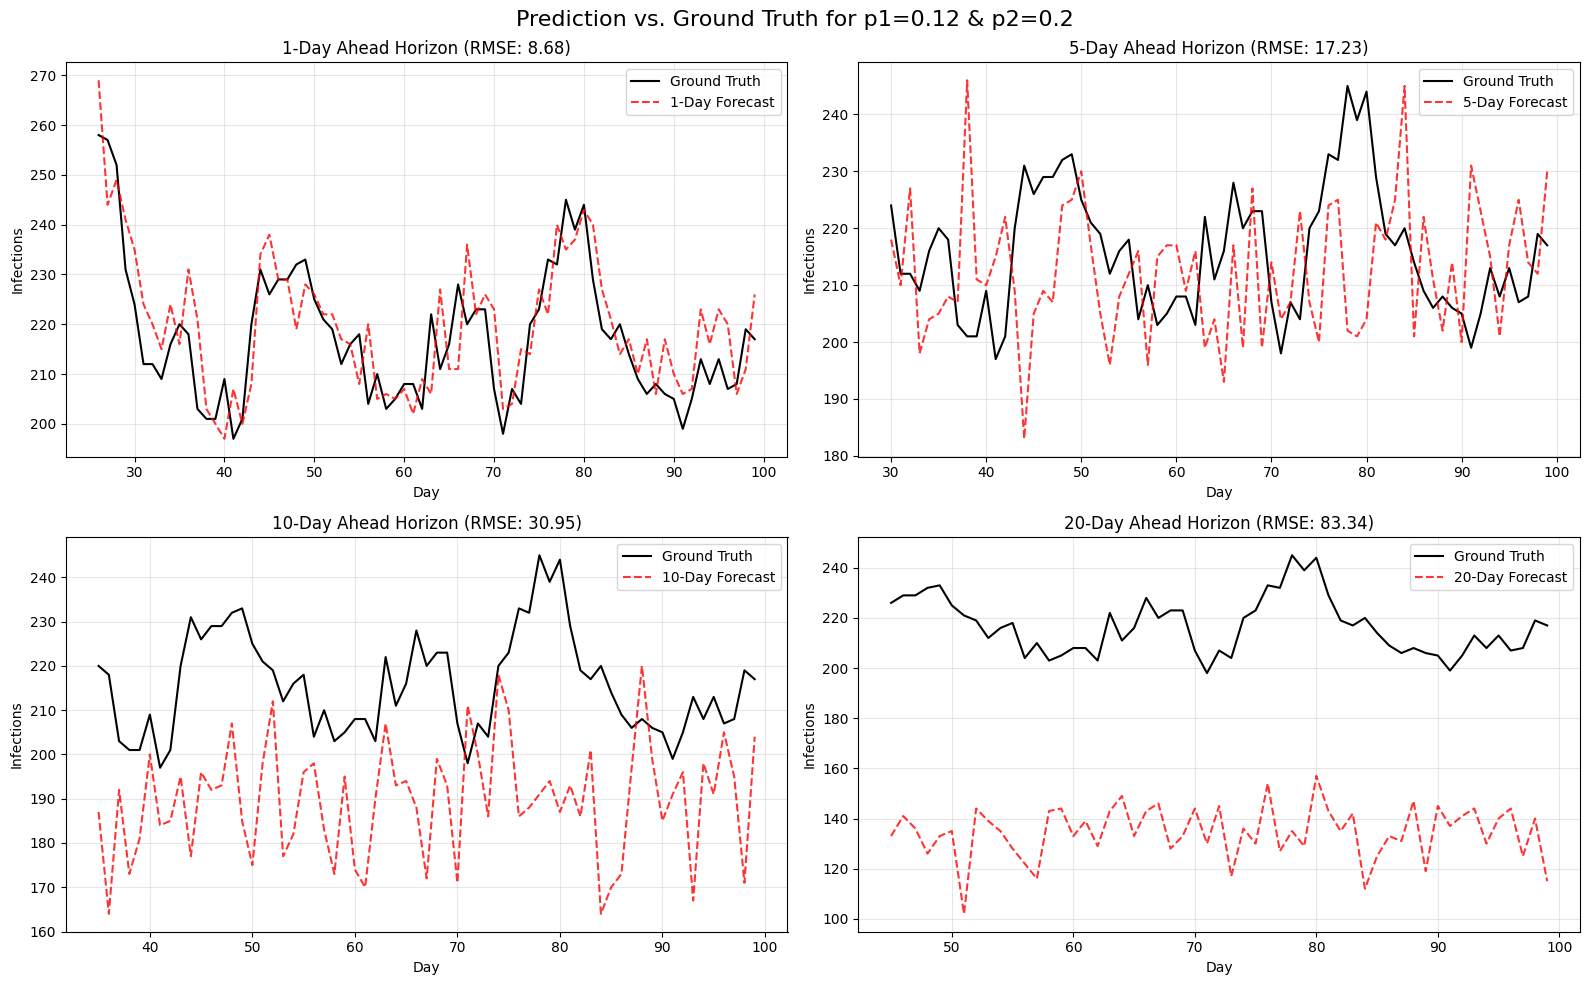


TABLE: 1-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       1           25          26        269     258
       1           26          27        244     257
       1           27          28        249     252
       1           28          29        241     231
       1           29          30        235     224

TABLE: 5-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
       5           25          30        218     224
       5           26          31        210     212
       5           27          32        227     212
       5           28          33        198     209
       5           29          34        204     216

TABLE: 10-DAY AHEAD (First 5)
 horizon  current_day  target_day  predicted  actual
      10           25          35        187     220
      10           26          36        164     218
      10           27          37        192     203
      10           28          38        173     201
      10

In [13]:
horizons = [1, 5, 10, 20]
start_eval = 25
max_day = 100
for p1, p2 in p:
    df_gt = pd.read_csv('data/p1_'+str(p1)+'_p2_'+str(p2)+'/states_total.csv')
    df_contacts = pd.read_csv('data/p1_'+str(p1)+'_p2_'+str(p2)+'/timed_edges.csv')
    print("Processing Contact Graph for "+str(p1)+","+str(p2)+"...")
    # Process Contacts into Dictionary
    contacts_dict = {}
    for day, group in df_contacts.groupby('day'):
        contacts_dict[day] = list(zip(group['i'], group['j']))
    # ==========================================
    # 3. RUN ROLLING ANALYSIS
    # ==========================================
    model_rolling = EpiInferContactRolling(list(range(2000)), contacts_dict, 7, 7)
    rows = []
    all_ids = list(range(2000))

    for current_day in range(start_eval, max_day):
        row_gt = df_gt[df_gt['day'] == current_day].iloc[0]
        count_A, count_I, count_R = int(row_gt['A']), int(row_gt['I']), int(row_gt['R'])

        random.shuffle(all_ids)
        seed_asymp = set(all_ids[:count_A])
        seed_inf = set(all_ids[count_A : count_A+count_I])
        seed_rec = set(all_ids[count_A+count_I : count_A+count_I+count_R])

        h_asymp, h_inf = {}, {}
        l_asymp, l_inf = list(seed_asymp), list(seed_inf)
        c_a, c_i = math.ceil(len(l_asymp)/7), math.ceil(len(l_inf)/7)
        for k in range(7):
            h_asymp[current_day - k] = set(l_asymp[k*c_a : (k+1)*c_a])
            h_inf[current_day - k] = set(l_inf[k*c_i : (k+1)*c_i])

        res = model_rolling.contact_infer_core_with_history(p1, p2, h_asymp, h_inf, current_day, min(current_day + 20, 99), seed_rec)

        for h in horizons:
            tgt = current_day + h
            if tgt in res and tgt < 100:
                pred = res[tgt]
                act = df_gt[df_gt['day'] == tgt]['I'].iloc[0]
                rows.append({'horizon': h, 'current_day': current_day, 'target_day': tgt, 'predicted': pred, 'actual': act})

    df_res = pd.DataFrame(rows)

    # ==========================================
    # 4. PLOTTING
    # ==========================================
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    fig.suptitle('Prediction vs. Ground Truth for p1=' + str(p1) + ' & p2=' + str(p2), fontsize=16)

    for idx, h in enumerate(horizons):
        ax = axes[idx]
        sub = df_res[df_res['horizon'] == h]

        ax.plot(sub['target_day'], sub['actual'], label='Ground Truth', color='black', linewidth=1.5)
        ax.plot(sub['target_day'], sub['predicted'], label=f'{h}-Day Forecast', color='red', linestyle='--', alpha=0.8)

        rmse = np.sqrt(((sub['predicted'] - sub['actual'])**2).mean())
        ax.set_title(f"{h}-Day Ahead Horizon (RMSE: {rmse:.2f})")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Day")
        ax.set_ylabel("Infections")

    plt.tight_layout()
    plt.savefig('horizons_plot_'+str(p1)+"_"+str(p2)+'.png')
    print("Plots saved.")
    plt.show()
    plt.close()

    # Print example tables for verification (first 5 rows)
    for h in horizons:
        print(f"\nTABLE: {h}-DAY AHEAD (First 5)")
        print(df_res[df_res['horizon']==h].head(5).to_string(index=False))